In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

In [2]:
np.random.seed(42)

In [3]:
# Load data
train_df = pd.read_csv('data/processed_train_data.csv')
test_df = pd.read_csv('data/processed_test_data.csv')

y_train = train_df['koi_disposition'].values
X_train = train_df.drop('koi_disposition', axis=1)
y_test = test_df['koi_disposition'].values
X_test = test_df.drop('koi_disposition', axis=1)

In [4]:
# Train the same stacking model
base_estimators = [
    ('random_forest', RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)),
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=200, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=5,
    n_jobs=-1
)

print("Training Stacking model...")
stacking_model.fit(X_train, y_train)

Training Stacking model...


,estimators,"[('random_forest', ...), ('gradient_boosting', ...)]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'auto'
,n_jobs,-1
,passthrough,False
,verbose,0
,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [6]:
# Random Forest importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'rf_importance': stacking_model.named_estimators_['random_forest'].feature_importances_
})

In [7]:
# Gradient Boosting importance
gb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'gb_importance': stacking_model.named_estimators_['gradient_boosting'].feature_importances_
})

In [8]:
# Combine importances
combined_importance = rf_importance.merge(gb_importance, on='feature')
combined_importance['avg_importance'] = (
    combined_importance['rf_importance'] + combined_importance['gb_importance']
) / 2
combined_importance = combined_importance.sort_values('avg_importance', ascending=False)

print("\nTop 20 Features (Average from both base estimators):")
print(combined_importance.head(20))


Top 20 Features (Average from both base estimators):
                             feature  rf_importance  gb_importance  \
26                     koi_model_snr       0.123892       0.452264   
13                      koi_duration       0.045197       0.048128   
14                 koi_duration_err1       0.063811       0.025423   
15                 koi_duration_err2       0.059861       0.018466   
10                        koi_impact       0.029421       0.042890   
29                    koi_steff_err1       0.034645       0.026907   
19                          koi_prad       0.028952       0.028176   
42  koi_tce_delivnameq1_q17_dr25_tce       0.013612       0.041512   
20                     koi_prad_err1       0.023168       0.028893   
30                    koi_steff_err2       0.029354       0.021183   
4                         koi_period       0.021398       0.028267   
9                   koi_time0bk_err2       0.044776       0.003497   
8                   koi_time0bk_err1

In [9]:
# Permutation importance on the full stacking model
print("\nCalculating permutation importance for full stacking model...")
perm_importance = permutation_importance(
    stacking_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

perm_df = pd.DataFrame({
    'feature': X_train.columns,
    'perm_importance': perm_importance.importances_mean
}).sort_values('perm_importance', ascending=False)


Calculating permutation importance for full stacking model...


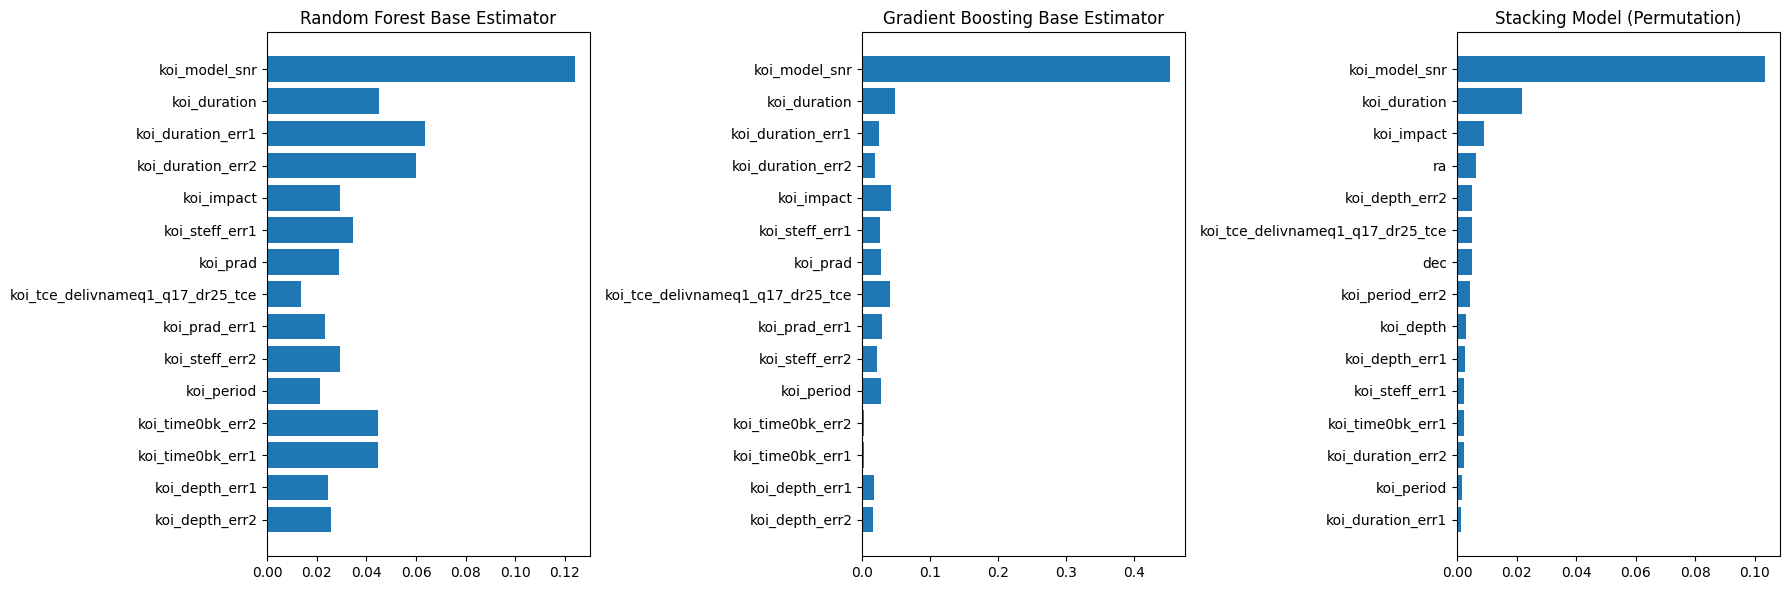


Results saved!


In [10]:
# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RF importance
axes[0].barh(combined_importance.head(15)['feature'], 
             combined_importance.head(15)['rf_importance'])
axes[0].set_title('Random Forest Base Estimator')
axes[0].invert_yaxis()

# GB importance
axes[1].barh(combined_importance.head(15)['feature'], 
             combined_importance.head(15)['gb_importance'])
axes[1].set_title('Gradient Boosting Base Estimator')
axes[1].invert_yaxis()

# Permutation on full stack
axes[2].barh(perm_df.head(15)['feature'], 
             perm_df.head(15)['perm_importance'])
axes[2].set_title('Stacking Model (Permutation)')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('stacking_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
combined_importance.to_csv('stacking_base_estimators_importance.csv', index=False)
perm_df.to_csv('stacking_permutation_importance.csv', index=False)

print("\nResults saved!")